In [1]:
# imports
import pandas as pd
import numpy as np
import findiff
from os import listdir
from sklearn.manifold import MDS
from scipy.stats import wasserstein_distance as wd
from matplotlib import pyplot as plt
import seaborn as sns         
from mvlearn.embed import MVMDS
from sklearn.cluster import KMeans
from sklearn import metrics

<h3>In all the CMS files, we find 33 motion sensors (99 columns since we have x,y,z) that are common amonst all of them (they are either named the same way or using an alternative name). i start by generating a variable "header" that will contain the names of each column using the names of the sensor (found in the variable called tmp) <br>if the CSM file we're trying to read contains 33 sensors, we use the header names directly, if it contains more, we need to only keep the columns of the 33 sensors we want.  

In [55]:
###reading data of a mouvement from the csm file
#name of columns , and their alternative naming
tmp = ['LFHD', 'RFHD', 'LBHD', 'RBHD', 'C7', 'CLAV', 'STRN', 'LSHO', 'LELB', 'LWRA', 'LWRB', 'LFIN', 'RSHO', 'RELB', 'RWRA', 'RWRB', 'RFIN', 'T10', 'SACR', 'LFWT', 'RFWT', 'LBWT', 'RBWT', 'LKNE', 'RKNE', 'LANK', 'RANK', 'LHEL', 'RHEL', 'LMT5', 'RMT5', 'LTOE', 'RTOE']
header2 = ['LFrontHead', 'RFrontHead', 'LBackHead', 'RBackHead', 'TopSpine', 'Sternum', 'Chest', 'LShoulder', 'LOuterElbow', 'LWristThumb', 'LWristPinky', 'LHand', 'RShoulder', 'ROuterElbow', 'RWristThumb', 'RWristPinky', 'RHand', 'MiddleBack', 'LowerBack', 'LFrontWaist', 'RFrontWaist', 'LBackWaist', 'RBackWaist', 'LOuterKnee', 'ROuterKnee', 'LAnkle', 'RAnkle', 'LHeel', 'RHeel', 'LOuterMeta', 'ROuterMeta', 'LToe', 'RToe']

header= []
for i in tmp:
    header.append(i+"_x")
    header.append(i+"_y")
    header.append(i+"_z")


distributions=[]#distribution de vitesse par mouvement (chaque element est une liste de distribution des differents capteurs)

#processing all the files in DataCSM folder
'''
 tmps vous aidera a parcourir tous les fichiers CSM dans le dossier DataCSM,
 pour lancer pour les fichiers test, mettez la prochaine ligne en commentaire
 et enlever le # de la ligne d'apres
'''
tmps = listdir("DataCSM") # current directory
#tmps = ["ale_lift_an_1_fin.csm","ali_lift_an_1_fin.csm","amc_lift_ha_1_fin.csm","emm_e_lift_ha_1_fin.csm"] #name of files used here for testing

for tmp in tmps:
    #read data
    try:
        data = pd.read_csv("DataCSM/"+tmp,skiprows=17,sep="\t",index_col=0,header=None)
        data = data.drop(columns=data.columns[-1]) #delete useless NA filled last column
    except pd.errors.ParserError: #contains "DROPOUT" as values for some sensors at the end, separated with spaces and not tabs, which messes up the parsins 
        data = pd.read_csv("DataCSM/"+tmp,skiprows=17,sep="\t",index_col=0,header=None,names=list(range(130))) #fix a number of columns so the parsing doesn't check size of result
    
    #if we don't have 33 sensors
    if (len(data.iloc[0])!=99):
        #finding header of data in the file
        with open("DataCSM/"+tmp,'r') as f:
            h=f.readlines()[14]
        h=h.split(' ')[:-1] #list of sensor names in the file

        #only keep index of columns that interest us (since this is a file with more than 33 sensors (99 columns) they use here the alternative names we have in header2)
        h = [h.index(i) for i in header2] #we only keep these

        for i in range(len(h)):
            i=h.pop(0)
            h.extend([i*3,i*3+1,i*3+2]) # to extract data of sensor 1, i'll need to take columns 1,2,3 (x,y,z). for sensor i, i'll need i*3,i*3+1,i*3+2
        data=data[h]
    
    data.columns=header #set col names

    #grad of each column
    dt = 1/60 # distance between two frames is (1/60)s
    grad=findiff.Gradient(h=[dt])
    vitesses=[] #liste rad vitesse inst
    for col in range(len(data.columns)):
        d = np.array(data[data.columns[col]])
        v = grad(d)
        vitesses.append(v[0])
    
    #processing distribution for each column (result of hist are couples (distribution,bins), so we take only the first part of the hist)
    distribution = []
    for v in vitesses:
        distribution.append(np.histogram(v,bins=101,range=[0,500])[0])
    
    distributions.append(distribution)

In [78]:
len(distributions[0]) #number of columns

99

<h3>In the following, we will compute the wassenstein distances between mouvements for each sensor. Meaning we will have 99 square matrix filled with wassenstein distances (in the variable Xs). We will then apply an MVMDS and visualize the results on a scatter plot. 

In [56]:
#processing the wassenstein distances and making the distance matrix for MDS (! for the first captor !)
nb_mvt = len(tmps) #nombre de mouvements
nb_sensors = len(distributions[0])
Xs = []

for k in range(nb_sensors):
    w_dist=np.empty((nb_mvt,nb_mvt))
    for i in range(nb_mvt):
        w_dist[i][i]=0
        for j in range(i+1,nb_mvt):
            w_dist[i][j] = w_dist[j][i] = wd(distributions[i][k],distributions[j][k])
    Xs.append(w_dist)
        
print(len(Xs))

99


In [61]:
'''#save wassenstein distance matrix Xs
f = open('Xs_no_af2.txt','w')
for i in range(len(Xs)):
    for j in range(len(Xs[i])):
        f.write(str(Xs[i][j][0]))
        for z in range (1,len(Xs[i][j])):
            f.write('\t'+str(Xs[i][j][z]))
        f.write('\n')
    f.write('\n')'''

In [3]:
'''
#read wassenstein distance matrix Xs
f = open("Xs_no_af.txt","r")
Xs=[]
w_dist=[]

for line in f:
    if (line != '\n'):
        w_dist.append(list(map(np.float64,line[:-1].split("\t"))))
    else :
        Xs.append(np.array(w_dist))
        w_dist=[]'''

In [30]:
len(Xs)

99

<h3>Now we use the Xs to calculate a 2D array to represent the similarities between the mouvements in the variable pts ( plus a part of the code to save / read the value of pts)

In [ ]:
from sklearn.manifold import TSNE
pts=TSNE().fit_transform(Xs[1])

In [ ]:
#using MVMDS
mds = MVMDS(dissimilarity='precomputed')
pts = mds.fit_transform(Xs)
mds.__dict__

In [ ]:
'''
#code utilisé pour ecrire les valeurs du pts dans un fichier pour eviter de tout recalculer inutilement la prochaine fois
f=open("pts.txt","w")
f.write('[['+str(pts[0,0])+','+str(pts[0,1])+']')
for i in range(1,len(pts)):
    f.write(",["+str(pts[i,0])+','+str(pts[i,1])+']')
f.write(']')
f.close()
'''

In [ ]:
'''#read processed pts from a file
pts=[]
f=open("pts(1).txt","r")
pts = f.readline()
pts=np.array(list(map(lambda x: list(map(float,x.split(','))),pts[2:-2].split('],['))))
f.close()
pts
'''

<h1> Visualisation

In [ ]:
tmps = listdir("CSM")
tmp = ['ha','an','fe','sad']*24
grp = {}
# for j in range(4):
for i in range(96):

   
    if tmp[i] not in grp.keys():
        
        grp[tmp[i]]=[[],[]]
    grp[tmp[i]][0].append(pts[i][0])
    grp[tmp[i]][1].append(pts[i][1])
        
fig = plt.figure(figsize=(10,10))
for i in range(len(grp.keys())):
    i = list(grp.keys())[i]
    ax = sns.scatterplot(x=grp[i][0], y=grp[i][1])
legend1 = ax.legend(grp.keys())
print(legend1)
ax.add_artist(legend1)

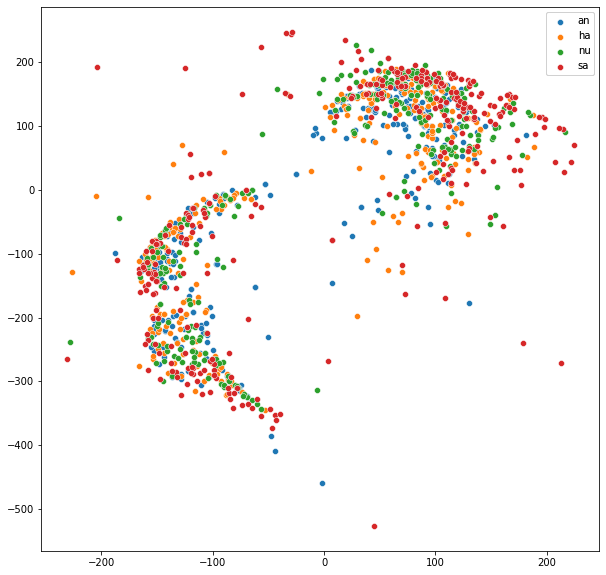

In [51]:
#visualize emotions (colors) only
tmps = listdir("DataCSM") # current directory

#grp = { 'emotion' : [ [x1,x2] , [y1,y2] , color ] , ...}
grp = {}
for i in range(len(tmps)):
    tmp = tmps[i].split("_")
    if tmp[-3] not in grp.keys():
        grp[tmp[-3]] =[[],[]]
    grp[tmp[-3]][0].append(pts[i][0])
    grp[tmp[-3]][1].append(pts[i][1])
fig = plt.figure(figsize=(10,10))
for i in range(len(grp.keys())):
    i = list(grp.keys())[i]
    ax = sns.scatterplot(x=grp[i][0], y=grp[i][1])
legend1 = ax.legend(grp.keys())
ax.add_artist(legend1)
    

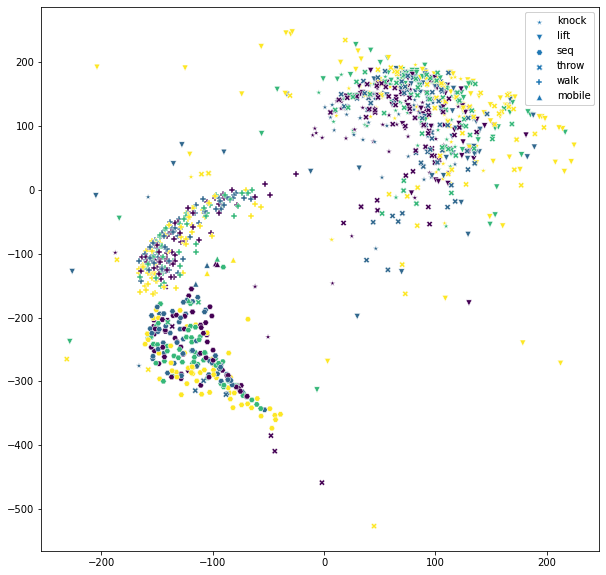

In [52]:
#Prep to visualize shapes (exercices) and colors (emitons)

tmps = listdir("DataCSM") # current directory
shapes = ["*","v","H","X","P","^"]
emotions = []

#grp = { 'exercice' : [ [x1,x2] , [y1,y2] , [color1,color2] ] , ...}
grp = {}

for i in range(len(tmps)):
    tmp = tmps[i].split("_")
    if tmp[-4] not in grp.keys():
        grp[tmp[-4]]=[ [],[],[] ]
    grp[tmp[-4]][0].append(pts[i][0])
    grp[tmp[-4]][1].append(pts[i][1])
    if tmp[-3] not in emotions:
        emotions.append(tmp[-3])
    grp[tmp[-4]][2].append(emotions.index(tmp[-3])*7)
fig = plt.figure(figsize=(10,10))
for i in range(len(grp.keys())):
    tmp=shapes[i]
    i = list(grp.keys())[i]
    ax = sns.scatterplot(x=grp[i][0], y=grp[i][1], c=grp[i][2], marker=tmp)
legend1 = ax.legend(grp.keys())
ax.add_artist(legend1)


<h1> Kmean and visualisation

In [63]:
kmeans = KMeans( n_clusters=4,random_state=0).fit(pts)
clusters = kmeans.labels_

Text(0.5, 1.0, 'Scattering into 4 clusters')

<Figure size 720x720 with 0 Axes>

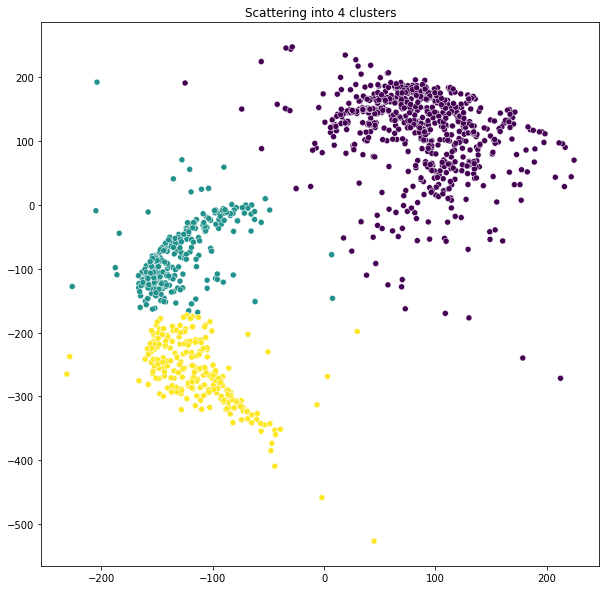

In [53]:
fig = plt.figure(figsize=(10,10))
X = []
Y = []
for i in range(len(pts)):
    X.append(pts[i][0])
    Y.append(pts[i][1])
fig = plt.figure(figsize=(10,10))
ax = sns.scatterplot(x=X,y=Y,c=kmeans.labels_)
plt.title("Scattering into 4 clusters")

<h1>Evaluation

In [ ]:
tmps = listdir("DataCSM") # current directory
ems = [] #TRUE emotions from file names
for i in tmps:
    ems.append(i.split("_")[-3])

In [20]:
comb_emo = emotions.copy() #list associating emotion-cluster
marked = [False]*len(emotions) #used in the making of combinations

best_acc = 0
best_acc_emo = []

best_mcc=-1
best_mcc_emo=[]

best_kappa=-1
best_kappa_emo=[]

def combinate ( cur_i ):
    '''
    Function to create different combinations of emotion-cluster associations

    example of combination :
    cluster 1 : af
            2 : an
            3 : ha
            4 : nu
            5 : sa
    '''
    global comb_emo, marked , best_acc, best_acc_emo, best_kappa, best_kappa_emo, best_mcc,best_mcc_emo
    if (cur_i == len(comb_emo)):
        #print(comb_emo)
        prediction=list(kmeans.labels_) #interpreting the cluster prediction as the emotion associated to it
        #replace labels with their name
        for i in range(len(prediction)):
            prediction[i] = comb_emo[prediction[i]]
        #print(metrics.confusion_matrix(ems,prediction))
        report = metrics.classification_report(ems,prediction)
        accuracy = report.split("\n")[-4].split(" ")[-7]
        if (float(accuracy) > best_acc):
            best_acc_emo = comb_emo.copy()
            best_acc = float(accuracy)
        #print(report)
        kappa = metrics.cohen_kappa_score(ems,prediction)
        #print("Kappa score : " + str(kappa))
        if (kappa > best_kappa):
            best_kappa_emo = comb_emo.copy()
            best_kappa = kappa
        mcc = metrics.matthews_corrcoef(ems,prediction)
        #print("Matthews corr coef : " + str(mcc))
        if (mcc > best_mcc):
            best_mcc_emo = comb_emo.copy()
            best_mcc = mcc
        return
    for i in range(len(emotions)):
        if (not marked[i]):
            marked[i] = True
            comb_emo[cur_i] = emotions[i]
            combinate( cur_i+1 )
            marked[i] = False

In [21]:
combinate(0)
print("="*30)
print("best accuracy found " + str(best_acc))
print(best_acc_emo)
print("best kappa ",best_kappa)
print(best_kappa_emo)
print("best mcc ",best_mcc)
print(best_mcc_emo)

best accuracy found 0.33
['ha', 'an', 'sa', 'nu']
best kappa  0.10716544698047525
['ha', 'an', 'sa', 'nu']
best mcc  0.10777374745545508
['ha', 'an', 'sa', 'nu']


visualisation of detailed rapport about the atribution of emotion-to-cluster that gives the best accuracy (the value of comb_emo to write manually) 

In [ ]:
comb_emo = ['ha', 'an', 'nu', 'sa']
prediction=list(kmeans.labels_)
for i in range(len(prediction)):
    prediction[i] = comb_emo[prediction[i]]
print(comb_emo)
print(metrics.classification_report(ems,prediction))
kappa = metrics.cohen_kappa_score(ems,prediction)
print("Kappa score : " + str(kappa))
mcc = metrics.matthews_corrcoef(ems,prediction)
print("Matthews corr coef : " + str(mcc))

<h3> trying other clustering methods

<h4> clustering methods

In [20]:
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=4)
clusters = model.fit_predict(pts)

In [17]:
from sklearn.cluster import Birch
model = Birch(threshold=0.01, n_clusters=4)
clusters = model.fit_predict(pts)

In [22]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=4)
clusters = model.fit_predict(pts)

<h4> visualisation of the clusters

Text(0.5, 1.0, 'Scattering into 4 clusters')

<Figure size 720x720 with 0 Axes>

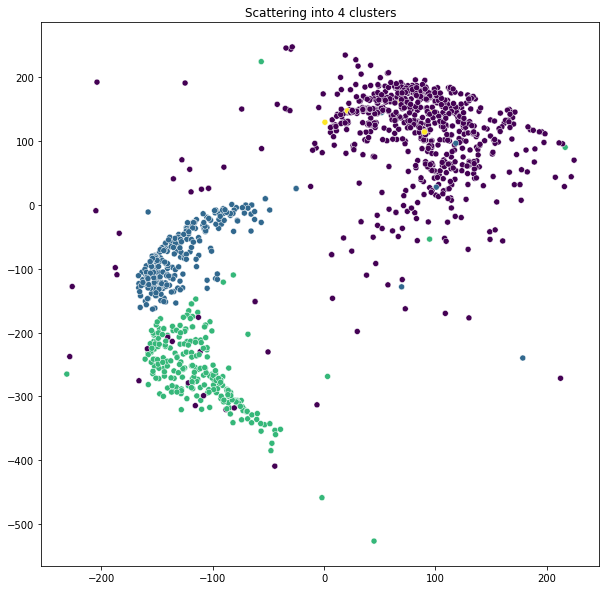

In [48]:
fig = plt.figure(figsize=(10,10))
X = []
Y = []
for i in range(len(pts)):
    X.append(pts[i][0])
    Y.append(pts[i][1])
fig = plt.figure(figsize=(10,10))
ax = sns.scatterplot(x=X,y=Y,c=clusters)
plt.title("Scattering into 4 clusters")

definition of an evaluation method to use with any cluster

In [40]:
comb_emo = emotions.copy() #list associating emotion-cluster
marked = [False]*len(emotions) #used in the making of combinations

best_acc = 0
best_acc_emo = []

best_mcc=-1
best_mcc_emo=[]

best_kappa=-1
best_kappa_emo=[]

def combinate ( cur_i ):
    '''
    Function to create different combinations of emotion-cluster associations

    example of combination :
    cluster 1 : af
            2 : an
            3 : ha
            4 : nu
            5 : sa
    '''
    global comb_emo, marked , best_acc, best_acc_emo, best_kappa, best_kappa_emo, best_mcc,best_mcc_emo
    if (cur_i == len(comb_emo)):
        #print(comb_emo)
        prediction=list(clusters.astype(int)) #interpreting the cluster prediction as the emotion associated to it
        #replace labels with their name
        for i in range(len(prediction)):
            prediction[i] = comb_emo[prediction[i]]
        #print(metrics.confusion_matrix(ems,prediction))
        report = metrics.classification_report(ems,prediction)
        accuracy = report.split("\n")[-4].split(" ")[-7]
        if (float(accuracy) > best_acc):
            best_acc_emo = comb_emo.copy()
            best_acc = float(accuracy)
        #print(report)
        kappa = metrics.cohen_kappa_score(ems,prediction)
        #print("Kappa score : " + str(kappa))
        if (kappa > best_kappa):
            best_kappa_emo = comb_emo.copy()
            best_kappa = kappa
        mcc = metrics.matthews_corrcoef(ems,prediction)
        #print("Matthews corr coef : " + str(mcc))
        if (mcc > best_mcc):
            best_mcc_emo = comb_emo.copy()
            best_mcc = mcc
        return
    for i in range(len(emotions)):
        if (not marked[i]):
            marked[i] = True
            comb_emo[cur_i] = emotions[i]
            combinate( cur_i+1 )
            marked[i] = False

Evaluation

In [ ]:
comb_emo = emotions.copy() #list associating emotion-cluster
marked = [False]*len(emotions) #used in the making of combinations

best_acc = 0
best_acc_emo = []

best_mcc=-1
best_mcc_emo=[]

best_kappa=-1
best_kappa_emo=[]

combinate(0)
print("="*30)
print("best accuracy found " + str(best_acc))
print(best_acc_emo)
print("best kappa ",best_kappa)
print(best_kappa_emo)
print("best mcc ",best_mcc)
print(best_mcc_emo)

In [ ]:
comb_emo = ['ha','sa','an', 'nu']
prediction=list(clusters)
for i in range(len(prediction)):
    prediction[i] = comb_emo[prediction[i]]
print(comb_emo)
print(metrics.classification_report(ems,prediction))
kappa = metrics.cohen_kappa_score(ems,prediction)
print("Kappa score : " + str(kappa))
mcc = metrics.matthews_corrcoef(ems,prediction)
print("Matthews corr coef : " + str(mcc))

Test new method: methode de vote <br> the idea is to do the determination of similarities and clustering for each captor instead of all of them at once.<br> for example this will tell us the first mouvement is part of cluster 1 in the clustering for the first column, and is part of cluster 2 of the clustering for the second column . . . we will then need to find a unification . meaning answer to a question : the cluster 1 in the first column (that represents an emotion) is equivalent to the cluster 2 in the second column (that should represent the same emotion). and to do so we check similarities between both clusterings. after this we unify the "name" of the cluster, meaning in columns 1 and 2, those clusters will be called 1. after that we will see which cluster was associated to that mouvement the most ofter (emotion) by vote from all the columns. and then associate a name to that cluster (name of emotion)

In [ ]:
from sklearn.manifold import TSNE
clusters = []
for i in range(len(Xs)):
    pts=TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(Xs[i])
    #pts=MDS(n_components=2).fit_transform(Xs[i])
    kmeans = KMeans( n_clusters=4,random_state=0).fit(pts)
    clusters.append(kmeans.labels_)
clusters_save = clusters.copy()

In [59]:
#############################################
votes = [ [[0 for i in range(4)]for i in range(4) ] for i in range(98) ] # len(ems) , len(ems),len (clusters) - 1 

for c0 in range(len(clusters[0])): ## indentify
	for cx in range(1,len(clusters)):
		votes[cx-1][clusters[0][c0]][clusters[cx][c0]] += 1
del c0
for cx in range(len(votes)): ### unify
	for i in range(4):#len(ems)
		max_j=0
		max_v = votes[cx][i][0]
		for j in range(1,4):#len ems
			if votes[cx][i][j]>max_v:
				max_v = votes[cx][i][j]
				max_j = j

		votes[cx][i] = max_j #the one that got most votes
	#votes[cx] est maintenant [a,b,c,d] indiquant que dans le cluster cx : 0 doit etre remplacé par a , 1 par b . . .
	for i in range(len(clusters[cx])):
		clusters[cx+1][i]=votes[cx][clusters[cx+1][i]]
del max_j, max_v, j
##vote
mvts = np.array(clusters).T
clusters = np.zeros(len(mvts))
for cx in range(len(mvts)):
	clusters[cx]=max(set(mvts[cx]), key = list(mvts[cx]).count)

In [45]:
#used to be save a copy of the clusters to avoid repeating the process
clusters_save = clusters.copy()